# Практическая работа №1:  
## Изучение возможности библиотек Python для решения задач цифровой обработки сигналов

Выполнил студент гр. 9381 Прибылов Никита.
Вариант 12.

## Постановка задачи  

1. Освоить Jupyter Notebook.  
1. Выполнить загрузку аудио сигнала и построить огибающую (график).  
1. Фильтрация (выбрать один из 4 основных типов фильтров). Получить фильтрованный сигнал.  
1. Детектор сигнал/шум. Получить сигнал после детектирования.  
1. Эффект ”Эхо”. Получить сигнал после работы аудио-эффекта.  
1. Бонусное задание: эффект ”Distortion”(классический вариант). Получить сигнал после работы аудио-эффекта.  

## Выполнение работы

In [1]:
from scipy.io import wavfile
from scipy import signal
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Audio
%matplotlib inline

In [2]:
audio_file_name = 'audio_12.wav'
sampling_rate, data = wavfile.read(audio_file_name)
Audio(data, rate=sampling_rate)

/tmp/ipykernel_21100/1616888380.py:2: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sampling_rate, data = wavfile.read(audio_file_name)


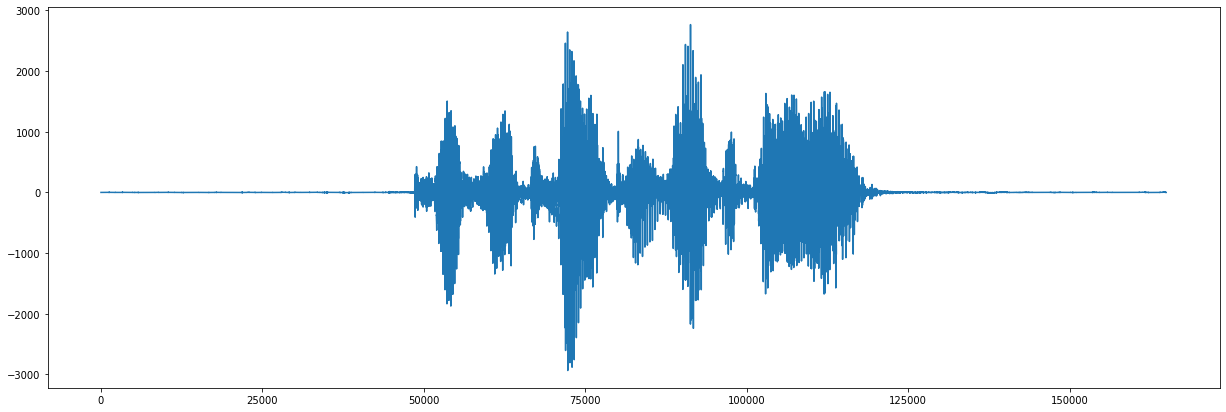

In [3]:
plt.rcParams["figure.figsize"] = (21,7)
plt.plot(data)

## Построение огибающей

Имеется сигнал $x(i)$, где $i=0,1,\dots,N-1$.  
Хотим построить огибающую $y(j)$, где $j=0,1,\dots,n-1$.  
Пусть $ m = \begin{bmatrix} \frac{N}{n} \end{bmatrix}$ - число точек в интервале усреднения. Тогда
$$y(j)=\frac{1}{m}\sum_{k=mj}^{mj+m-1}|x(k)|$$  

Длина огибающей: 206
Количество точек в интервале: 800


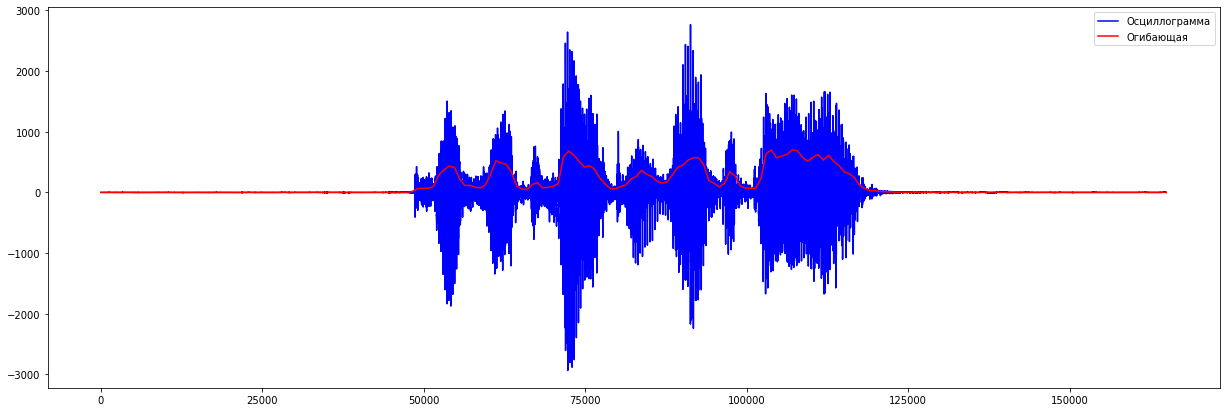

In [4]:
m = 800 # количество точек в интервале
en_len = int(len(data) / m) # длина огибающей
print(f'Длина огибающей: {en_len}\nКоличество точек в интервале: {m}')

envelope = [sum(abs(data[k]) for k in range(j*m, (j+1)*m)) / m for j in range(en_len)] # расчёт огибающей
en_t = np.linspace(0, len(data), len(envelope))
plt.plot(data, label='Осциллограмма', color='blue')
plt.plot(en_t, envelope, label='Огибающая', color='red')
plt.legend(loc='upper right')

## Полосовой фильтр  

Фильтрация полосовым фильтром.  
Пусть $F_d$ - частота дискретизации, частота среза - $F_s$.  
Порядок фильтра - $m$. Тогда вычисляем $wn=2\frac{F_s}{F_d}$.  

In [5]:
order = 6 # порядок фильтра
critical_frequencies = [300, 3400] # частоты среза
wn = [2 * cf / sampling_rate for cf in critical_frequencies]

b, a = signal.butter(order, wn, 'bandpass')
filtedData = signal.filtfilt(b, a, data)
Audio(filtedData, rate=sampling_rate)

## Детектор сигнал/шум  

Определяем среднее сигнала по амплитуде(без учета знака):  
$$mid=\frac{\sum^{N-1}_{k=0}|x(k)|}{N}$$

Определяем порог детектора - $Th=\alpha*mid$, где $0<\alpha<1$ подбирается экспериментально.  
Задаем величину "провала"(в отсчетах) - $k$. Обозначим $y(i)$ - сигнал после детектирования. 

1. **Событие "начало сигнала"**. Если $x(i)$ в течение $k$ отсчетов превышает порог, $y(i)=x(i)$.  
1. **Событие "окончание сигнала"**. Если $x(i)$ в течение $k$ отсчетов меньше порога, $y(i)=0$. 

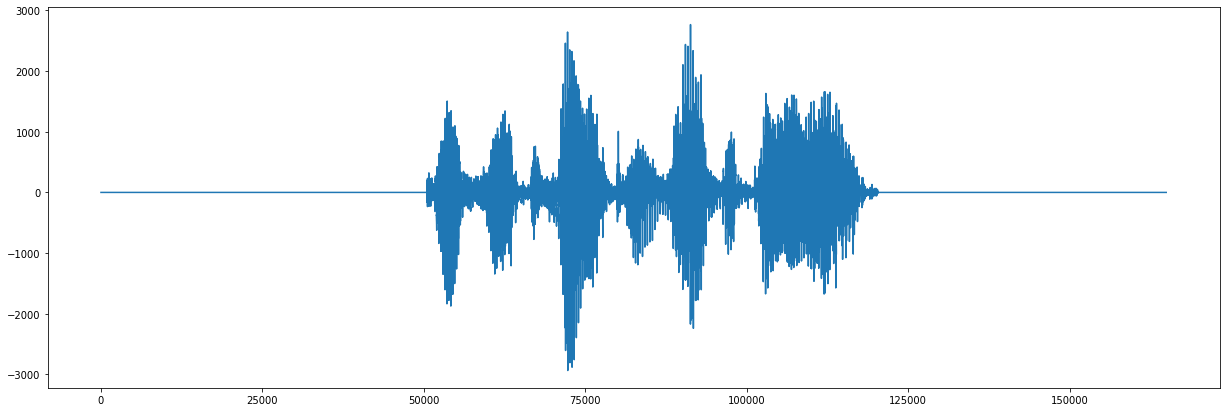

In [6]:
newData = data
mid = sum(abs(newData[k]) for k in range(len(newData))) / len(newData)
alpha = 0.09
threshold = alpha * mid
filteredData = data.copy()
k = 50
gt_th = k+1
lt_th = 0
for i in range(k, len(data)):
    if abs(data[i]) > threshold:
        if gt_th > k:
            filteredData[i] = data[i]
            lt_th = 0
        else:
            filteredData[i] = 0
            gt_th += 1
    else:
        if lt_th > k:
            filteredData[i] = 0
            gt_th = 0
        else:
            filteredData[i] = data[i]
            lt_th += 1
            
#plt.plot(data)
plt.plot(filteredData)
wavfile.write('filtered.wav', sampling_rate, filteredData)
Audio(filteredData, rate=sampling_rate)

## Эхо (простейший ревербератор)  

Ревербератор состоит из 8 линий задержки. Каждая линия задержки имеет свой весовой коэффициент. Перед добавлением к исходному сигналу, выход ревербератора фильтруется ФНЧ-фильтром первого порядка. Соотношение между начальным и обработанным сигналом задается коэффициентом применимости $\gamma=0.9$.  

Значения задержек:  
$$D_i=D_1*2^{\frac{1-i}{N_L}}$$  
где $i=2,\dots,8$ и $D_1$ - максимальная задержка.  

Весовые коэффициенты при линиях задержек: $\alpha_i=1-\frac{i}{10}$, где $i=1,\dots,8$  

In [7]:
delay = 0.2
gamma = 0.9 
Di = [delay*(2**((-i)/8)) for i in range(8)]
alpha = [ 1/(i+1) for i in range(8)]
all_samples = [alpha[i] * data for i in range(8)]
Fs = 900
wn = 2 * Fs / sampling_rate
m = 1
b, a = signal.butter(m, wn, "lowpass")
all_samples = list(map(lambda x: gamma*signal.filtfilt(b, a, x), all_samples))
echo_sound = np.zeros(int((np.sum(Di) + len(data) / sampling_rate + 1) * sampling_rate))
for i in range(8):
    if i >= 1:
        Di[i] += Di[i-1]
    for j in range(len(all_samples[i])):
        echo_sound[j + int(Di[i] * sampling_rate)] += all_samples[i][j]
for i in range(len(data)):
    echo_sound[i] += data[i]


wavfile.write("echo.wav", sampling_rate, echo_sound.astype(np.int16))
Audio(echo_sound, rate=sampling_rate)

## Эффект "Distortion"  

Обозначим входной сигнал и выходной сигналы, соответственно как $x(i)$ и $y(i)$, где $i=0,1,\dots,N-1$.  
Пользователь задает **порог** - $Th$ и максимальное значение сигнала $Max>Th$. Тогда  
$$Y(i) = \
\left\{\
\begin{matrix}
 &x(i)&|x(i)|<Th\\ 
 &Max*sign(x(i))&|x(i)|>Th 
\end{matrix}\
\right.$$


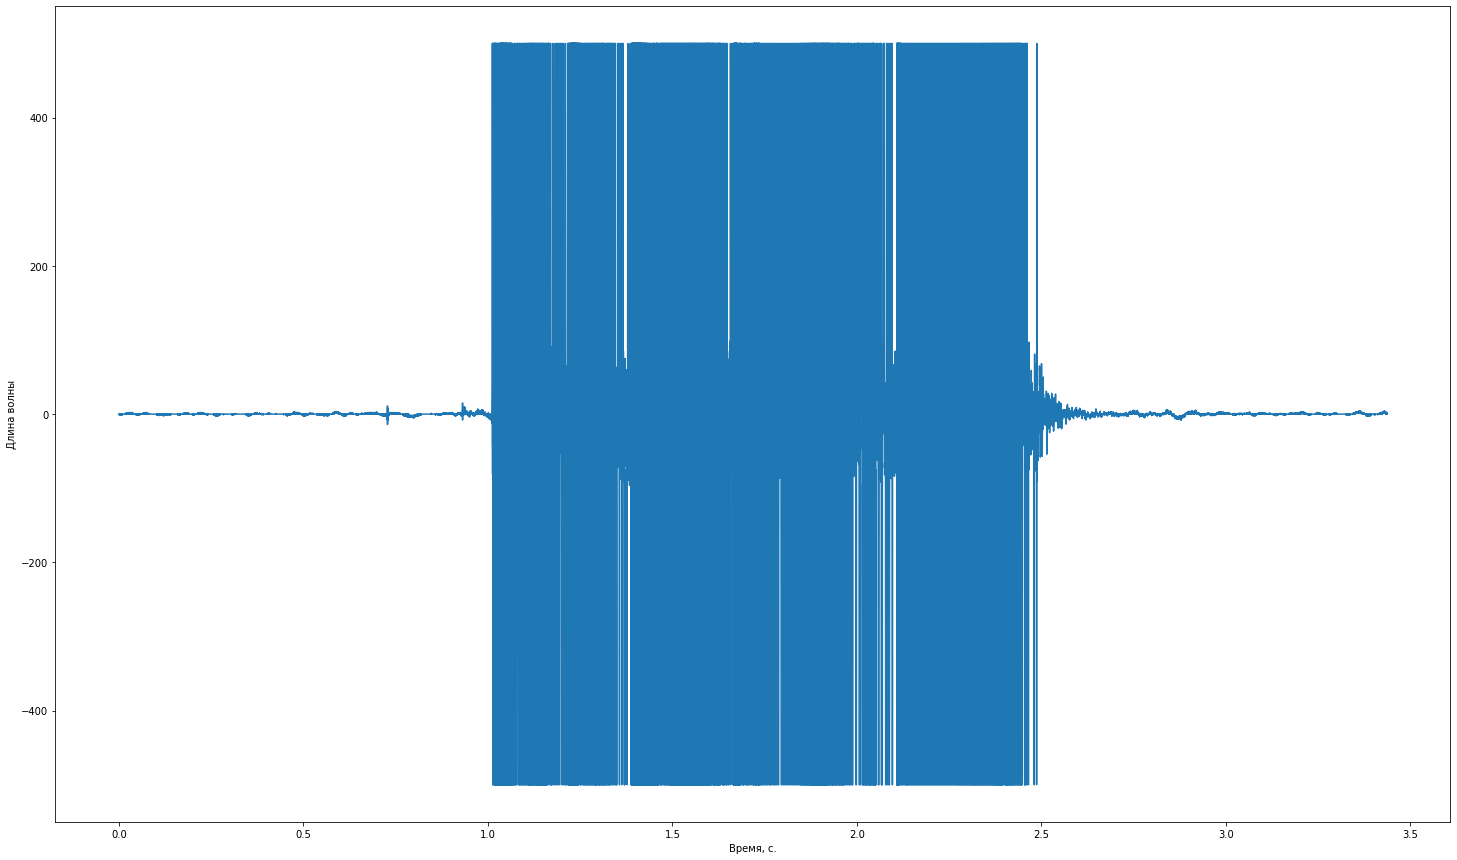

In [8]:
Th = 100
mx = 500
sound_time = data.size / sampling_rate
distortion = data[::]
for i in range(distortion.size):
    distortion[i] = distortion[i] if abs(distortion[i]) < Th else mx*np.sign(distortion[i])
plt.rcParams["figure.figsize"]=25, 15
plt.plot(np.linspace(0, sound_time, data.size), distortion)
plt.xlabel("Время, с.")
plt.ylabel("Длина волны")
plt.show()

wavfile.write("distortion.wav", sampling_rate, distortion.astype(np.int16))
Audio(distortion, rate=sampling_rate)

## Вывод  

В ходе выполнения лабораторной работы были изучены возможности библиотек Python для решения задач цифровой обработки сигналов, а также были написаны методы обработки сиглалов с использованием пакета ***scipy***.